In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [2]:
import numpy as np
from scipy import ndimage

from polygon import get_polygon

from tqdm import tqdm

import os

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [3]:
""" 

    where am i?

"""

PATH = os.getcwd()
data_path = PATH.replace( '01_square_156_256', '' ) + 'data/01_square/01_square_1000000_156_256/'

print( f'PATH: { PATH }' )
print( f'data_path: { data_path }' )

PATH: /Users/no_lineal/Documents/draft_code/grid_metrics/01_square_156_256
data_path: /Users/no_lineal/Documents/draft_code/grid_metrics/data/01_square/01_square_1000000_156_256/


In [4]:
""" 

    load correlation matrix

"""

ratemap_mat = np.load( data_path + 'grid_scores/ratemap.npy' )

sac_max_mat = np.load( data_path + 'grid_scores/sac/max/sac.npy' )

print('')
print( f'ratemap_mat: { ratemap_mat.shape }' )
print('')
print( f'sac_max_mat: { sac_max_mat.shape }' )
print('')


ratemap_mat: (512, 32, 32)

sac_max_mat: (512, 63, 63)



In [5]:
""" 

    border score

"""

def border_score( ratemap, res, width ):

    pix_area = ((100**2)*(width**2))/(res**2) # ??

    rm_th = ratemap > np.nanmax( ratemap * 0.3 )
    rm_comps, ncomps = ndimage.measurements.label( rm_th )

    # keep fields with area > 200 cm^2
    masks = []
    nfields = 0
    for i in range(1, ncomps+1):

        mask = ( rm_comps == i ).reshape( res, res )

        if mask.sum()*pix_area > 141:
            
            masks.append( mask )
            nfields += 1

    # get max coverage
    cm_max = 0
    for mask in masks:

        mask = masks[0]
        n_cov = mask[0].mean()
        s_cov = mask[-1].mean()
        e_cov = mask[:,0].mean()
        w_cov = mask[:,-1].mean()
        cm = np.max([n_cov,s_cov,e_cov,w_cov])

        if cm>cm_max:
            cm_max = cm

    # distanc e to nearest wall
    x,y = np.mgrid[:res,:res] + 1
    x = x.ravel()
    y = y.ravel()
    xmin = np.min(np.vstack([x,res+1-x]),0)
    ymin = np.min(np.vstack([y,res+1-y]),0)
    dweight = np.min(np.vstack([xmin,ymin]),0).reshape(res,res)
    dweight = dweight*width/res

    # mean firing distances
    dms = []
    for mask in masks:
        field = ratemap[mask]
        field /= field.sum()   # normalize
        dm = (field*dweight[mask]).sum()
        dms.append(dm)
    dm = np.nanmean(dms) / (width/2)
    border_score = (cm_max-dm)/(cm_max+dm)

    return border_score, cm_max, dm

polygon_ = get_polygon( 'square', area=1.56**2, factor=1 )

# coord range
min_x, min_y, max_x, max_y = polygon_.bounds
coord_range = ( (min_x, max_x), (min_y, max_y) )

width = max_x - min_x

res = 32

border_scores_mat = []
cms_mat = []
dms_mat = []

for i in tqdm( range( ratemap_mat.shape[0] ) ):

    ratemap = ratemap_mat[i]
    bscore, cm_max, dm = border_score( ratemap, res, width )

    border_scores_mat.append( bscore )
    cms_mat.append( cm_max )
    dms_mat.append( dm )

border_scores_mat = np.array( border_scores_mat )
cms_mat = np.array( cms_mat )
dms_mat = np.array( dms_mat )

print('')
print( f'border_scores_mat: { border_scores_mat.shape }' )
print( f'border score nan: { np.isnan(border_scores_mat).sum() }' )
print( f'cms_mat: { cms_mat.shape }' )
print( f'dms_mat: { dms_mat.shape }' )
print('')

save = True

if save:

    #np.save( data_path + 'grid_scores/sac/max/border.npy', sac_max_border_mat )
    np.save( data_path + 'grid_scores/border.npy', border_scores_mat )

  0%|          | 0/512 [00:00<?, ?it/s]/var/folders/g5/_2g0311j2w93w086_s60pvtc0000gn/T/ipykernel_91649/2176915400.py:12: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  rm_comps, ncomps = ndimage.measurements.label( rm_th )
/var/folders/g5/_2g0311j2w93w086_s60pvtc0000gn/T/ipykernel_91649/2176915400.py:56: RuntimeWarning: Mean of empty slice
  dm = np.nanmean(dms) / (width/2)
100%|██████████| 512/512 [00:00<00:00, 3214.34it/s]


border_scores_mat: (512,)
border score nan: 1
cms_mat: (512,)
dms_mat: (512,)



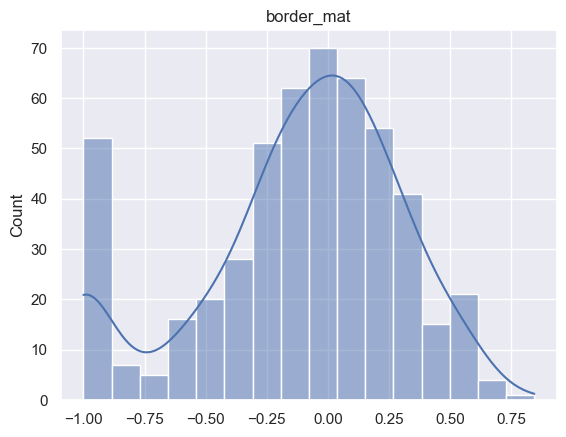

In [6]:
""" 

    viz distribution

"""

fig, ax = plt.subplots( 1, 1 )

sns.histplot( border_scores_mat, kde=True )
ax.set_title( 'border_mat' )

plt.show()